<a href="https://colab.research.google.com/github/sunfflur/frequency-learning/blob/master/EyeQ/Exp_EyeQ.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Experiment EyeQ database

> In this experiment, two classes of the EyeQ dataset were explored: good and reject.

> Considering these two classes, 22,358 images were used for training and evaluating
the models, according to the following division:

----- Training set – 8,347 images of good category and 2,320 images of reject category;

----- Validation set – 8,471 images of good category and 3,220 images of reject category.

`Author:` [sunfflur](https://github.com/sunfflur)


---

#### Libraries Import

In [1]:
s = 23
import os
os.environ['PYTHONHASHSEED']=str(s)
import random
random.seed(s)
from numpy.random import seed
seed(s)
import tensorflow as tf
#import tensorflow
tf.random.set_seed(s)
#from tensorflow.random import set_seed
#set_seed(s)

import PIL
import numpy as np

from tensorflow.keras.layers import Layer, Dense, Conv1D, Dropout, MaxPooling2D, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.utils import to_categorical, image_dataset_from_directory
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sn
import time

!pip install autokeras
!pip install tensorflow-addons 
!pip install tensorflow-recommenders

import tensorflow_addons as tfa
import tensorflow_recommenders as tfrs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 162 kB 14.3 MB/s 
     |████████████████████████████████| 135 kB 104.6 MB/s 
     |████████████████████████████████| 1.6 MB 78.0 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 13.5 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 89 kB 7.0 MB/s 


In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon Dec  5 18:01:01 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P0    29W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


#### Drive mount

In [4]:
### TESSSSSST ###

!sudo add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!sudo apt-get update -qq 2>&1 > /dev/null
!sudo apt -y install -qq google-drive-ocamlfuse 2>&1 > /dev/null
!google-drive-ocamlfuse




debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
/usr/bin/xdg-open: 851: /usr/bin/xdg-open: www-browser: not found
/usr/bin/xdg-open: 851: /usr/bin/xdg-open: links2: not found
/usr/bin/xdg-open: 851: /usr/bin/xdg-open: elinks: not found
/usr/bin/xdg-open: 851: /usr/bin/xdg-open: links: not found
/usr/bin/xdg-open: 851: /usr/bin/xdg-open: lynx: not found
/usr/bin/xdg-open: 851: /usr/bin/xdg-open: w3m: not found
xdg-open: no method available for opening 'https://accounts.google.com/o/oauth2/auth?client_id=564921029129.apps.googleusercontent.com&redirect_uri=https%3A%2F%2Fgd-ocaml-auth.appspot.

In [5]:
!sudo apt-get install -qq w3m # to act as web browser 
!xdg-settings set default-web-browser w3m.desktop # to set default browser
%cd /content
!mkdir drive
%cd drive
!mkdir MyDrive
%cd ..
%cd ..
!google-drive-ocamlfuse /content/drive/MyDrive

debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package w3m.
(Reading database ... 124020 files and directories currently installed.)
Preparing to unpack .../w3m_0.5.3-36build1_amd64.deb ...
Unpacking w3m (0.5.3-36build1) ...
Setting up w3m (0.5.3-36build1) ...
Processing triggers for mime-support (3.60ubuntu1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
/content
/content/drive
/content
/
Access token retrieved correctly.


#### Image Main Functions

In [ ]:
### blocks ###
def slice(image, levels):
  if levels == 0:
    image = tf.transpose(image, [0, 3, 1, 2])
    return image
  iM, iN = image.shape[1], image.shape[2]
  iMc, iNc = int(iM/2), int(iN/2)
  output = tf.stack((image[:, :iMc, :iNc], image[:, :iMc,iNc:], image[:, iMc:,:iNc], image[:, iMc:, iNc:]),-1)
  output = tf.reshape(output,[output.shape[0],output.shape[1],output.shape[2],-1])
  return slice(output, levels-1)

In [ ]:
### DFT ### 
def m_spectrum(image):
  side = image.shape[2]
  inputx = tf.cast(image, tf.complex128) # change dtype to complex64 
  fft = tf.signal.fft2d(inputx) # perform fast fourier transform
  fft_shift = tf.signal.fftshift(fft, axes=(2,3)) # shift the zero-frequency component to the center

  # calculate the magnitude and scale it
  magnitude = tf.math.abs(fft_shift) 
  magnitude = tf.math.divide(magnitude, side**2)
  magnitude = tf.math.log(1+magnitude)

  return magnitude

In [ ]:
### magnitude sums ###
def radial_grouping(image, r):
  iM, iN = image.shape[2], image.shape[3] #image dimension
  iMc, iNc = int(iM/2), int(iN/2) #image center
  A = tf.range(-iMc,iNc)**2
  dists = tf.math.sqrt(tf.cast(A[:,None] + A, dtype=tf.float32))
  dists = tf.reshape(dists, [1,1,image.shape[2],image.shape[3]]) #1,1,128,128
  n = int(iNc/r) #rings number
  r = (r/2)
  magnitude_sums = []
  ring = 0
  for j in range(1, 2*n, 2):
    ring = tf.cast((tf.abs(dists-r*j)<r), dtype=tf.float32)
    if j == 1:
      ring = tf.cast((tf.abs(dists-(r/2)*j)<=(r/2)), dtype=tf.float32)
    mult = tf.multiply(ring,image)
    sum = tf.reduce_sum(mult,axis=(2,3))
    magnitude_sums.append(sum.numpy())
  magnitude_sums = tf.transpose(tf.convert_to_tensor(magnitude_sums))
  magnitude_sums = tf.reshape(magnitude_sums, [magnitude_sums.shape[1], magnitude_sums.shape[2], magnitude_sums.shape[0]])
  magnitude_sums = tf.reshape(magnitude_sums, [magnitude_sums.shape[0], -1])
  return magnitude_sums

In [ ]:
### magnitude sums ###
def square_grouping(image, r):
  iM, iN = image.shape[2], image.shape[3] #img.shape
  iMc, iNc = int(iM/2), int(iN/2) #image center
  n = int(iNc/r) #rings number
  ring = np.full((iM,iN), 0)
  magnitude_sums = []
  for w in range(r, (n*r)+1, r):
    ring[iMc-w:iMc+w,iNc-w:iNc+w] = 1
    ring[iMc-w + r :iMc+w -r ,iNc-w +r :iNc+w -r] = 0
    mult = tf.multiply(ring,image)
    sum = tf.reduce_sum(mult,axis=(2,3))
    magnitude_sums.append(sum.numpy())
  magnitude_sums = tf.transpose(tf.convert_to_tensor(magnitude_sums))
  magnitude_sums = tf.reshape(magnitude_sums, [magnitude_sums.shape[1], magnitude_sums.shape[2], magnitude_sums.shape[0]])
  magnitude_sums = tf.reshape(magnitude_sums, [magnitude_sums.shape[0], -1])
  return magnitude_sums

#### Image Main Functions - Per Image

In [ ]:
### blocks PER IMAGE ###
def slice_data(images, levels):
  outputs = []
  if levels == 0:
    dim = int(tf.rank(images))
    if dim == 3:
      #print(images.shape)
      images = tf.expand_dims(images, -1)
      images = tf.transpose(images, [0, 3, 1, 2])
      return images
    else:
      images = tf.transpose(images, [0, 3, 1, 2])
      return images
  for image in images:
    #print('image shape?', image.shape)
    iM, iN = image.shape[0], image.shape[1] #512,512
    iMc, iNc = int(iM/2), int(iN/2) #512/2,512/2
    output = tf.stack((image[:iMc, :iNc], image[:iMc,iNc:], image[iMc:,:iNc], image[iMc:, iNc:]),-1)
    output = tf.reshape(output,[output.shape[0],output.shape[1], -1]) #256,256,4
    outputs.append(output)
  outputs = tf.convert_to_tensor(outputs)
  return slice_data(outputs, levels-1)

In [ ]:
### DFT PER IMAGE ### 
def m_spectrum(images):
  magnitudes = []
  for image in images:
    side = image.shape[1]
    inputx = tf.cast(image, tf.complex128) # change dtype to complex64
    fft = tf.signal.fft2d(inputx) # perform fast fourier transform
    fft_shift = tf.signal.fftshift(fft, axes=(1,2)) # shift the zero-frequency component to the center
    # calculate the magnitude and scale it
    magnitude = tf.math.abs(fft_shift)
    magnitude = tf.math.divide(magnitude, side**2) # do not change here !!!
    magnitude = tf.math.log(1+magnitude)
    magnitudes.append(magnitude)
  return tf.convert_to_tensor(magnitudes)

In [ ]:
def NormalizeData(X, max=1, min=0):
    ### data normalization between 0-1
    X_std = (X - tf.math.reduce_min(X)) / (tf.math.reduce_max(X) - tf.math.reduce_min(X))
    X_scaled = X_std * (max - min) + min
    return X_scaled

In [ ]:
def DHT(images):
  fhts = []
  for image in images:
    side = image.shape[1]
    inputx = tf.cast(image, tf.complex128) # change dtype to complex64
    #print('inputx', inputx.shape)
    fft = tf.signal.fft2d(inputx) # perform fast fourier transform
    fft_shift = tf.signal.fftshift(fft, axes=(1,2)) # shift the zero-frequency component to the center
    real = tf.math.real(fft_shift)
    imag = tf.math.imag(fft_shift)

    # calculate the hartley transform from the real and imaginary parts of the FFT
    FHT = real - imag
    FHT = tf.math.divide(FHT, side**2)
    #FHT = tf.math.sign(FHT)*tf.math.log(tf.math.abs(FHT)+1)
    FHT = tf.math.abs(tf.math.asinh(FHT))
    #FHT = tf.math.asinh(FHT)
    fhts.append(FHT)
  return tf.convert_to_tensor(fhts)

In [ ]:
### magnitude sums PER IMAGE ###
def radial_grouping(images, r):
  grouping = []
  for image in images:
    iM, iN = image.shape[1], image.shape[2] #image dimension
    iMc, iNc = int(iM/2), int(iN/2) #image center
    A = tf.range(-iMc,iNc)**2
    dists = tf.math.sqrt(tf.cast(A[:,None] + A, dtype=tf.float64))
    dists = tf.reshape(dists, [1,image.shape[1],image.shape[2]]) #1,512,512
    n = int(iNc/r) #rings number
    magnitude_sums = []
    ring = 0
    for j in range(1, 2*n, 2):
      ring = tf.cast((tf.abs(dists-(r/2)*j)<(r/2)), dtype=tf.float64)
      if j == 1:
        ring = tf.cast((tf.abs(dists-(r/2)*j)<=(r/2)), dtype=tf.float64)
      mult = tf.multiply(ring,image)
      sum = tf.reduce_sum(mult,axis=(1,2))
      magnitude_sums.append(sum.numpy())
    magnitude_sums = tf.convert_to_tensor(magnitude_sums)
    grouping.append(magnitude_sums)
  grouping = tf.convert_to_tensor(grouping)
  grouping = tf.reshape(grouping, [grouping.shape[0], -1])
  return grouping

In [ ]:
### magnitude sums PER IMAGE ###
def square_grouping(images, r):
  grouping = []
  for image in images:
    iM, iN = image.shape[1], image.shape[2] #image dimension
    iMc, iNc = int(iM/2), int(iN/2) #image center
    A = tf.range(-iMc,iNc)**2
    n = int(iNc/r) #rings number
    ring = np.full((iM,iN), 0)
    magnitude_sums = []
    for w in range(r, (n*r)+1, r):
      ring[iMc-w:iMc+w,iNc-w:iNc+w] = 1
      ring[iMc-w + r :iMc+w -r ,iNc-w +r :iNc+w -r] = 0
      mult = tf.multiply(ring, image)
      #print('mult:', mult)
      sum = tf.reduce_sum(mult,axis=(1,2))
      magnitude_sums.append(sum.numpy())
    magnitude_sums = tf.convert_to_tensor(magnitude_sums)
    grouping.append(magnitude_sums)
  grouping = tf.convert_to_tensor(grouping)
  grouping = tf.reshape(grouping, [grouping.shape[0], -1])
  return grouping

#### Custom Layer

In [6]:
### frequency layer constrution ###

class FreqLayer(Layer):
  def __init__(self, units, kernel_initializer='RandomNormal', extra_layers='Dense', output_type='Dense', **kwargs):
    super().__init__(**kwargs)
    self.units = units
    self.kernel_initializer = kernel_initializer
    self.extra_layers = extra_layers
    self.output_type = output_type
  def get_config(self):
    config = super(FreqLayer, self).get_config()
    config.update({
      "units": self.units,
      "kernel_initializer": self.kernel_initializer,
      "extra_layers": self.extra_layers,
      "output_type": self.output_type
      })
    return config
  def build(self, batch_input_shape):
    if self.extra_layers == 'Dense':
      shape = [batch_input_shape[-1]] #(weights,) - shape for dense training
    else:
      shape = [batch_input_shape[-2],1] #(weights, 1) - shape for convolutional training
    self.kernel = self.add_weight(
        name='kernel',
        shape = shape,
        initializer=self.kernel_initializer,
        trainable=True)
    super().build(batch_input_shape) # must be at the end
  def call(self, X):
    #### fourier convolution ####
    f = X*self.kernel

    #### hartley convolution ####
    #f = conv(X, self.kernel)

    return f
  def compute_output_shape(self, batch_input_shape):
    if self.output_type == 'Dense':
      return tf.TensorShape(batch_input_shape.as_list()[:-1] + [self.units]) #[examples,1] - dense
    else:
      return tf.TensorShape(batch_input_shape.as_list()[:-2] + [self.units]) #[examples,1] - conv1d


#### Data Load Functions

In [7]:
"""#### Data Load"""

### Saved Pre-Processed data LOAD ###

def Load(path_train=None, y_train=None, path_valid=None, y_valid=None, path_test=None, y_test=None, extra_layers='Dense'):
  y_train, y_test = tf.stack(np.load(y_train)), tf.stack(np.load(y_test))
  if extra_layers=='Dense':
    if path_valid!=False:
      input_train = tf.convert_to_tensor(np.load(path_train)) ### train 
      input_valid = tf.convert_to_tensor(np.load(path_valid)) ### valid
      input_test = tf.convert_to_tensor(np.load(path_test)) ### test
      return input_train, y_train, input_valid, y_valid, input_test, y_test
    else:
      input_train = tf.convert_to_tensor(np.load(path_train)) ### train 
      input_test = tf.convert_to_tensor(np.load(path_test)) ### test
      return input_train, y_train, input_test, y_test
  else:
    if path_valid!=False:
      input_train = tf.convert_to_tensor(np.load(path_train)) ### train 
      input_train = tf.expand_dims(input_train, -1)
      input_valid = tf.convert_to_tensor(np.load(path_valid)) ### valid
      input_valid = tf.expand_dims(input_valid, -1)
      input_test = tf.convert_to_tensor(np.load(path_test)) ### test
      input_test = tf.expand_dims(input_test, -1)
      return input_train, y_train, input_valid, y_valid, input_test, y_test
    else:
      input_train = tf.convert_to_tensor(np.load(path_train)) ### train 
      input_train = tf.expand_dims(input_train, -1)
      input_test = tf.convert_to_tensor(np.load(path_test)) ### test
      input_test = tf.expand_dims(input_test, -1)
      return input_train, y_train, input_test, y_test
  #return input_train, input_valid, input_test


def input_split(x=None, image_shape=None, levels=3, ch=1):
  coefs1 = int((image_shape/2)/2) #
  #ch = 3 #channels

  # layer 3 (global)
  C = x[:, 0:coefs1*ch] #TensorShape([3360, 384])

  # layer 2
  B = x[:, coefs1*ch:(coefs1*ch)+(2*coefs1*ch)] #TensorShape([3360, 768])

  # layer 1 (local)
  A = x[:, (coefs1*ch)+(2*coefs1*ch):(coefs1*ch)+(2*coefs1*ch)+(4*coefs1*ch)] #TensorShape([3360, 1536]) 

  return A, B, C

#### Plots

In [66]:

def my_violin_plot(data_to_plot, labels=['A', 'B'], xlabel='Sample name', ylabel='Observed values', title='Title', cm='Pastel2_r',
                   savefig_path=None):

    # Create a figure instance
    fig = plt.figure(figsize=(9,4))
    
    quartile1, medians, quartile3 = np.percentile(data_to_plot, [25, 50, 75], axis=1) #axis=0
    inds = np.arange(1, len(medians) + 1)

    ax = fig.add_subplot(111)
    ax.xaxis.set_major_locator(MultipleLocator(1))
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.set_xticks(np.arange(1, len(labels) + 1), labels=labels)
    ax.set_xticklabels(labels)

    ax.scatter(inds, medians, marker='o', color='white', s=20, zorder=3)

    # Create the boxplot
    bp = ax.violinplot(data_to_plot, showmeans=True, showmedians=True)

    heights = [violin.get_paths()[0].get_extents().height for violin in bp['bodies']]
    norm = plt.Normalize(min(heights), max(heights))
    cmap = plt.get_cmap(cm)


    # Make all the violin statistics marks red:
    for partname in ('cbars','cmins','cmaxes','cmeans','cmedians'):
        vp = bp[partname]
        vp.set_edgecolor('black')
        vp.set_linewidth(0.5)

    # Make the violin body a cmap with black borders
    for violin, height in zip(bp['bodies'], heights):
         violin.set_color(cmap(norm(height)))
         violin.set_edgecolor('gray')
         violin.set_alpha(1.0)
         violin.set_linewidth(0.5)

    #plt.colorbar(ScalarMappable(norm=norm, cmap=cmap), alpha=violin.get_alpha(), ax=ax) #label='Violin Extent'
    #plt.tight_layout()
    plt.savefig(savefig_path)
    plt.show()


### TRAIN/VALIDATION EVOLUTION PLOT ###

def evolution_curves_plot(history, language='pt-br'):
    if language=='en':
        plt.figure(figsize=(10,4))
        plt.plot(history.history['loss'], 'r-', label='Training loss')
        plt.plot(history.history['val_loss'], 'r--', label='Validation loss')
        plt.plot(history.history['accuracy'], 'g-', label = 'Training accuracy')
        plt.plot(history.history['val_accuracy'], 'g--', label = 'Validation accuracy')
        plt.xlabel('Epoch', fontsize=14), plt.ylabel('Magnitude', fontsize=14)
        plt.title('Loss and Accuracy evolution', fontsize=14)
        plt.legend(loc='best')
        plt.show()
    elif language=='pt-br':
        plt.figure(figsize=(10,4))
        plt.plot(history.history['loss'], 'r-', label='Perda de treinamento')
        #plt.plot(history.history['val_loss'], 'r--', label='Perda de validação')
        plt.plot(history.history['accuracy'], 'g-', label = 'Acurácia de treinamento')
        #plt.plot(history.history['val_accuracy'], 'g--', label = 'Acurácia de validação')
        plt.xlabel('Época', fontsize=14), plt.ylabel('Magnitude', fontsize=14)
        plt.title('Evolução de perda e acurácia', fontsize=14)
        plt.legend(loc='best')
        plt.show()

### CONFUSION MATRIX PLOT ###

def confusion_matrix_plot(data, y_test, model, language='pt-br'): 
    y_pred = model.predict(data)
    plt.figure(figsize = (12,8))
    cm = confusion_matrix(tf.argmax(y_test, axis=1), tf.argmax(y_pred, axis=1))
    acc = np.trace(cm)/data.shape[0] * 100
    erros = tf.reduce_sum(cm)-tf.linalg.trace(cm)
    if language=='en':
        plt.title('Test set - accuracy %.2f%% / %d incorrect classifications' % (acc, erros), fontsize=14)
    elif language=='pt-br':
        plt.title('Conjunto de teste - %.2f%% de acurácia / %d classificações incorretas' % (acc, erros), fontsize=14)
    labels = ['good','reject']
    sn.heatmap(cm, cmap='Pastel1_r', linewidths=.1, annot=True, fmt=".6g", xticklabels=labels, yticklabels=labels)
    plt.xlabel('y_pred',fontsize=14)
    plt.ylabel('y_test',fontsize=14)
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.show()

### INCORRECT CLASSIFICATION EXAMPLES PLOT ###

def incorrect_class_plot(data, x_test, y_test, model):
    dic = {0:'blanket1',1:'blanket2',2:'canvas1',3:'ceiling1',4:'ceiling2',5:'cushion1',
           6:'floor1',7:'floor2',8:'grass1',9:'lentils1',10:'linseeds1',11:'oatmeal1',
           12:'pearlsugar1',13:'rice1',14:'rice2',15:'rug1',16:'sand1',17:'scarf1',
           18:'scarf2',19:'screen1',20:'seat1',21:'seat2',22:'sesameseeds1',23:'stone1',
           24:'stone2',25:'stone3',26:'stoneslab1',27:'wall1'}

    y_pred = model.predict(data)
    dif = tf.argmax(y_test, axis=1)-tf.argmax(y_pred, axis=1)
    indices = np.where(dif!=0)[0]
    plt.figure(figsize=(14,6))
    plt.subplot(121), plt.imshow(tf.squeeze(x_test[indices[0]]), cmap='gray')
    r1 = tf.argmax(y_test, axis=1)[indices[0]]
    f1 = tf.argmax(y_pred, axis=1)[indices[0]]
    p1=np.amax((y_pred)[indices[0]])

    #t1 = "Actual class = {}\nPredicted class = {}\nPrediction probability = {:.2f} %" \
    #            .format(dic[int(r1)], dic[int(f1)], p1*100)
    t1 = "Classe verdadeira = {}\nClasse predita = {}\nProbabilidade de predição = {:.2f} %" \
                .format(dic[int(r1)], dic[int(f1)], p1*100)
    #plt.title('Classe: %s - Predição: %s' % (dic[int(r1)], dic[int(f1)]))
    #plt.title('Class: %s - Prediction: %s' % (dic[int(r1)], dic[int(f1)]))
    plt.title(t1,fontsize=14)

    p2=np.amax((y_pred)[indices[1]])
    plt.subplot(122), plt.imshow(tf.squeeze(x_test[indices[1]]), cmap='gray')
    r2 = tf.argmax(y_test, axis=1)[indices[1]]
    f2 = tf.argmax(y_pred, axis=1)[indices[1]]
    #plt.title('Classe: %s - Predição: %s' % (dic[int(r2)], dic[int(f2)]))
    #plt.title('Class: %s - Prediction: %s' % (dic[int(r2)], dic[int(f2)]))
    #t2 = "Actual class = {}\nPredicted class = {}\nPrediction probability = {:.2f} %" \
    #            .format(dic[int(r2)], dic[int(f2)], p2*100)
    t2 = "Classe verdadeira = {}\nClasse predita = {}\nProbabilidade de predição = {:.2f} %" \
                .format(dic[int(r2)], dic[int(f2)], p2*100)
    plt.title(t2,fontsize=14)
    #plt.subplot(133), plt.imshow(tf.squeeze(x_test[indices[2]]), cmap='gray')
    #r3 = tf.argmax(y_test, axis=1)[indices[2]]
    #f3 = tf.argmax(y_pred, axis=1)[indices[2]]
    #plt.title('Classe: %s - Predição: %s' % (dic[int(r3)], dic[int(f3)]))
    plt.show()

### FREQUENCY LAYER WEIGHTS PLOT ###

def freq_weights_plot(model):
    plt.figure(figsize=(9,3))
    plt.plot(model.get_weights()[0])
    #plt.plot(model.get_weights()[1])
    #plt.plot(model.get_weights()[2])
    #plt.plot(model.get_weights()[3])
    plt.title('Camada em frequência',fontsize=14)
    #plt.title('Frequency Layer')
    plt.xlabel('Raio (r)',fontsize=14), plt.ylabel('Pesos',fontsize=14)
    #plt.xlabel('Radius (r)'), plt.ylabel('Weights')
    plt.show()

#### Data Pre-Process - 3 levels

In [ ]:
class PreProcess():
  def __init__(self, data, level, r): #level = levels number; r = radius (ring width);
    self.data = data #x_train/test
    self.level = level
    self.r = r
  def processing(self):
    conc_channels = []
    for i in range(0, self.level+1):
      print('level:', i)
      for j in range(0, self.data.shape[3]):
        print('channel:', j)
        sliced_data = slice_data(self.data[:,:,:,j], levels=i)
        dht_data = DHT(sliced_data)
        #dft_data = m_spectrum(sliced_data)
        #grouping_data = radial_grouping(dft_data, r=self.r) # r = radius (ring width)
        #grouping_data = square_grouping(dft_data, r=self.r) # r = radius (ring width)
        grouping_data = square_grouping(dht_data, r=self.r) # r = radius (ring width)
        conc_channels.append(grouping_data)
        #del sliced_data
        #del dht_data
        #del grouping_data
      conc = tf.concat((conc_channels), axis=1)
    input = np.asarray(tf.concat((conc), axis=1))
    #input = tf.expand_dims(input, axis=-1)
    #print(input.shape)
    ### data normalization between 0-1
    #scaler = MinMaxScaler()
    #inp = scaler.fit_transform(input) #N,weights 
    inp = NormalizeData(input)
    #inp = tf.math.asinh(input)
    input = tf.convert_to_tensor(inp)
    return input, sliced_data, dht_data

#### Pre-processed data LOAD

In [10]:
### Saved Pre-Processed data LOAD ###

input_train, y_train, input_test, y_test = Load(path_train='/content/drive/MyDrive/Mestrado/Experimentos/exp-eyeq/exp-eyeq-data/square-grouping/3-levels/input_train_eyeq_l2_w1_square512_fft.npy',
                                                y_train='/content/drive/MyDrive/Mestrado/Experimentos/exp-eyeq/exp-eyeq-data/square-grouping/3-levels/y_train.npy',
                                                path_valid=False,
                                                y_valid=False,
                                                path_test='/content/drive/MyDrive/Mestrado/Experimentos/exp-eyeq/exp-eyeq-data/square-grouping/3-levels/input_test_eyeq_l2_w1_square512_fft.npy',
                                                y_test='/content/drive/MyDrive/Mestrado/Experimentos/exp-eyeq/exp-eyeq-data/square-grouping/3-levels/y_test.npy',
                                                extra_layers='Dense')

In [12]:
input_train.shape

TensorShape([10667, 5376])

In [13]:
input_test.shape

TensorShape([11691, 5376])

#### Model

In [53]:
test_accuracies = []
total_times = []
mean = []
t_mean = []

optimizers = ['Adam']
for index, opt in enumerate(optimizers):
    print('>>> current optimizer:', opt)
    acc = []
    tempos = []
    for m in range(0, 1):
        print(">>>>>>>>>> test:", m)
        ### reset session ###
        tf.keras.backend.clear_session()
        ### dense ###
        tf.random.set_seed(0) #s
        init = 'glorot_normal' #glorot_normal
        function = 'LeakyReLU' #LeakyReLU
        model = Sequential([
        FreqLayer(1, kernel_initializer=tf.keras.initializers.RandomNormal(mean=0, stddev=0.01)), #0.01
        Dense(64, activation=function, #128 original
              kernel_initializer=init, bias_initializer=init),
        Dropout(0.25), #0.25
        Dense(32, activation=function, #128
             kernel_initializer=init, bias_initializer=init),
        Dropout(0.15),  #0.15
        Dense(32, activation=function, 
             kernel_initializer=init, bias_initializer=init),    
        Dense(2, activation='softmax')])
        
        """ Optimizers """

        ### inverse time decay  ###
        bs=32 #32
        inversetime_decay = tf.keras.optimizers.schedules.InverseTimeDecay(
          initial_learning_rate = 0.01, #0.01
          decay_steps = input_train.shape[0]/bs,
          decay_rate = 0.01) #0.01

        ### optimizers ###
        d_m=0.9 #momentum - dense layers 0.8

        if opt == 'Adam':
            opt = Adam(learning_rate=0.001, amsgrad=True) #0.001
        elif opt == 'SGD':
            opt = tfrs.experimental.optimizers.CompositeOptimizer([
                  (SGD(learning_rate=inversetime_decay, momentum=0.0), lambda: [model.layers[0].kernel]),
                  (SGD(learning_rate=inversetime_decay, momentum=d_m), lambda: model.layers[1].weights),
                  (SGD(learning_rate=inversetime_decay, momentum=d_m), lambda: model.layers[2].weights),
                  (SGD(learning_rate=inversetime_decay, momentum=d_m), lambda: model.layers[3].weights),
                  (SGD(learning_rate=inversetime_decay, momentum=d_m), lambda: model.layers[4].weights),
                  (SGD(learning_rate=inversetime_decay, momentum=d_m), lambda: model.layers[5].weights),   
                  (SGD(learning_rate=inversetime_decay, momentum=d_m), lambda: model.layers[6].weights)])
        
        model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

        inicio = time.time()
        history =  model.fit(input_train, y_train, epochs=700, batch_size=bs, verbose=2, shuffle=True, validation_split=0.05)
        fim = time.time()
        tempo = fim-inicio
        print("time:", tempo)

        ### TEST ACC ###
        scores = model.evaluate(input_test, y_test)
        print('\ntest %s: %.2f%%' % (model.metrics_names[1], scores[1] * 100))
        acc.append(scores[1])
        tempos.append(tempo)
    accuracies = tf.convert_to_tensor(acc)
    t = tf.convert_to_tensor(tempos)
    mean.append(tf.reduce_mean(accuracies))
    t_mean.append(tf.reduce_mean(t))
    test_accuracies.append(accuracies)
    total_times.append(t)
    
print('test_accuracies:', test_accuracies) #SGD and Adam
print('mean accuracy:', mean)
print('total_time:', total_times) #SGD and Adam
print('mean time:', t_mean)

>>> current optimizer: Adam
>>>>>>>>>> test: 0
Epoch 1/700
317/317 - 2s - loss: 0.3113 - accuracy: 0.8711 - val_loss: 0.0774 - val_accuracy: 0.9831 - 2s/epoch - 6ms/step
Epoch 2/700
317/317 - 1s - loss: 0.1164 - accuracy: 0.9646 - val_loss: 0.0958 - val_accuracy: 0.9682 - 957ms/epoch - 3ms/step
Epoch 3/700
317/317 - 1s - loss: 0.1028 - accuracy: 0.9701 - val_loss: 0.0654 - val_accuracy: 0.9794 - 952ms/epoch - 3ms/step
Epoch 4/700
317/317 - 1s - loss: 0.0939 - accuracy: 0.9715 - val_loss: 0.0548 - val_accuracy: 0.9869 - 947ms/epoch - 3ms/step
Epoch 5/700
317/317 - 1s - loss: 0.0874 - accuracy: 0.9741 - val_loss: 0.0442 - val_accuracy: 0.9869 - 941ms/epoch - 3ms/step
Epoch 6/700
317/317 - 1s - loss: 0.0869 - accuracy: 0.9736 - val_loss: 0.0440 - val_accuracy: 0.9850 - 939ms/epoch - 3ms/step
Epoch 7/700
317/317 - 1s - loss: 0.0852 - accuracy: 0.9738 - val_loss: 0.0389 - val_accuracy: 0.9906 - 937ms/epoch - 3ms/step
Epoch 8/700
317/317 - 1s - loss: 0.0809 - accuracy: 0.9771 - val_loss: 0.0

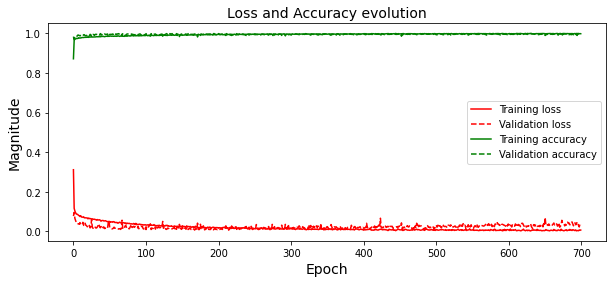

In [67]:
""" TRAIN/VALIDATION EVOLUTION PLOT """
evolution_curves_plot(history=history, language='en')

366/366 [==============================] - 1s 2ms/step


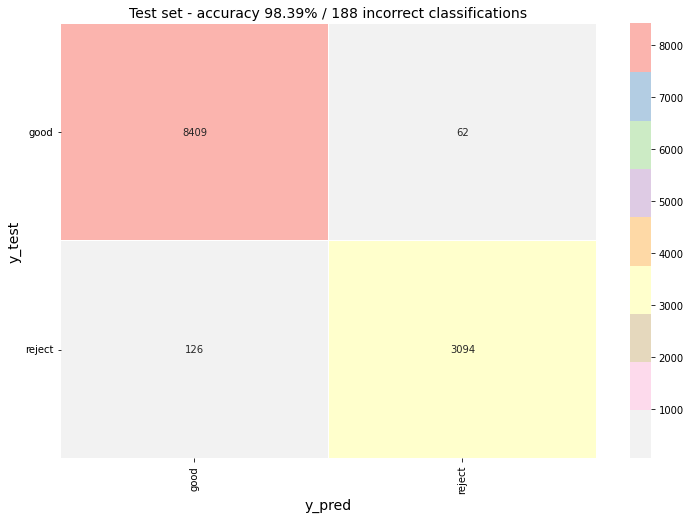

In [56]:
""" CONFUSION MATRIX PLOT """

confusion_matrix_plot(data=input_test, y_test=y_test, model=model, language='en')

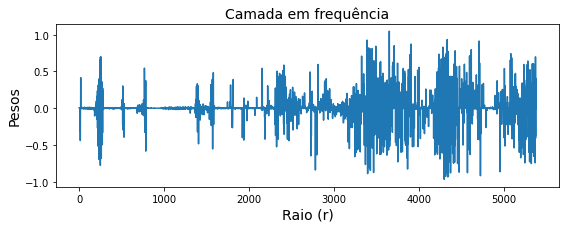

In [57]:
""" FREQUENCY LAYER WEIGHTS PLOT """

freq_weights_plot(model=model)

In [58]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 freq_layer (FreqLayer)      (None, 5376)              5376      
                                                                 
 dense (Dense)               (None, 64)                344128    
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 32)                1056      
                                                                 
 dense_3 (Dense)             (None, 2)                 6